In [ ]:
!pip install stopwords
!pip install flair
!pip install nltk
!pip install swifter
!pip install transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 9.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-no

In [ ]:
import pandas as pd
import numpy as np
import flair
import re
import nltk
import string
import matplotlib.pyplot as plt
import random as rn
import seaborn as sns
import torch
import transformers
from flair.data import Sentence
from nltk.corpus import stopwords
from wordcloud import WordCloud
from transformers import AutoTokenizer
from nltk import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from datasets import Dataset
from datasets import load_metric
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
nltk.download('stopwords')
nltk.download('punkt')
pd.options.display.max_rows = None

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/steam-dataset.csv')
# Rimuovere eventuali righe con valori NaN
df.dropna(subset=['app_name', 'review_score', 'review_text'], inplace=True)
df = df.sample(n=6000, random_state=1)
df['review_score'].mask(df['review_score'] == -1, 0, inplace=True)

In [ ]:
temp = df.groupby('review_score').count()['review_text'].reset_index().sort_values(by='review_text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,review_score,review_text
1,1,4933
0,0,1067


<Axes: xlabel='review_score', ylabel='count'>

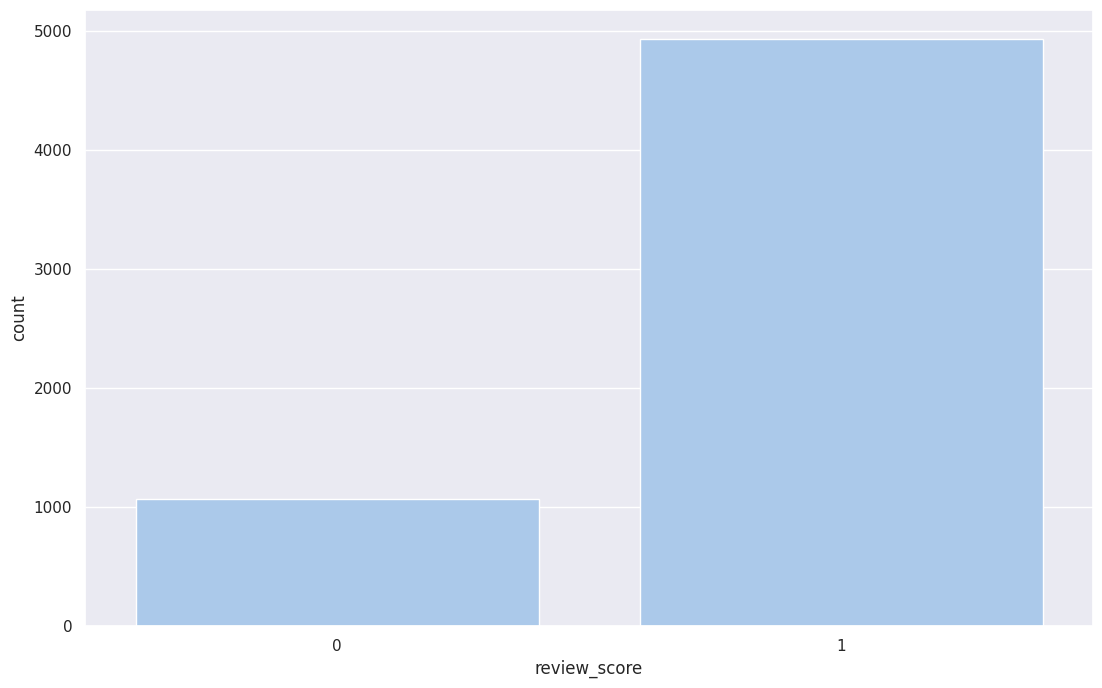

In [ ]:
sns.set_theme(style='whitegrid')
sns.set(rc = {'figure.figsize':(13,8)})
sns.set_palette("pastel")
sns.countplot(x='review_score',data=df)

DATA CLEANING

In [ ]:
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

In [ ]:
def remove_num(texts):
   output = re.sub(r'\d+', '', texts)
   return output

In [ ]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

In [ ]:
def unify_whitespaces(x):
    cleaned_string = re.sub(' +', ' ', x)
    return cleaned_string

In [ ]:
def remove_symbols(x):
    cleaned_string = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', x)
    return cleaned_string

In [ ]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',','))
    return final

In [ ]:
stop=set(stopwords.words("english"))
stemmer=PorterStemmer()
lemma=WordNetLemmatizer()

def remove_stopword(text):
   text=[word.lower() for word in text.split() if word.lower() not in stop]
   return " ".join(text)

In [ ]:
def Stemming(text):
   stem=[]
   stopword = stopwords.words('english')
   snowball_stemmer = SnowballStemmer('english')
   word_tokens = nltk.word_tokenize(text)
   stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
   stem=' '.join(stemmed_word)
   return stem

In [ ]:
def cleaning(df,review):
    df[review] = df[review].apply(clean)
    df[review] = df[review].apply(deEmojify)
    df[review] = df[review].str.lower()
    df[review] = df[review].apply(remove_num)
    df[review] = df[review].apply(remove_symbols)
    df[review] = df[review].apply(remove_punctuation)
    df[review] = df[review].apply(remove_stopword)
    df[review] = df[review].apply(unify_whitespaces)
    df[review] = df[review].apply(Stemming)

In [ ]:
cleaning(df,'review_text')
df[['review_text']].head(20)

,review_text
2076493,im big fan side scroll game recommend tri anyw...
3095669,earli access review
2394020,far good fun combat heap stealth section posit...
637482,sorta like art style gameplay tripl titl ad mo...
960680,would definit recommend game friend fast pace ...
5486878,earli access review
5635708,cant say enjoy game cant say hate whole experi...
2764416,earli access review
4085959,asid various small glitch gold show earn quest...
1455505,enjoy game larg extent


In [ ]:
positive = df[df['review_score']==1]
negative = df[df['review_score']==0]

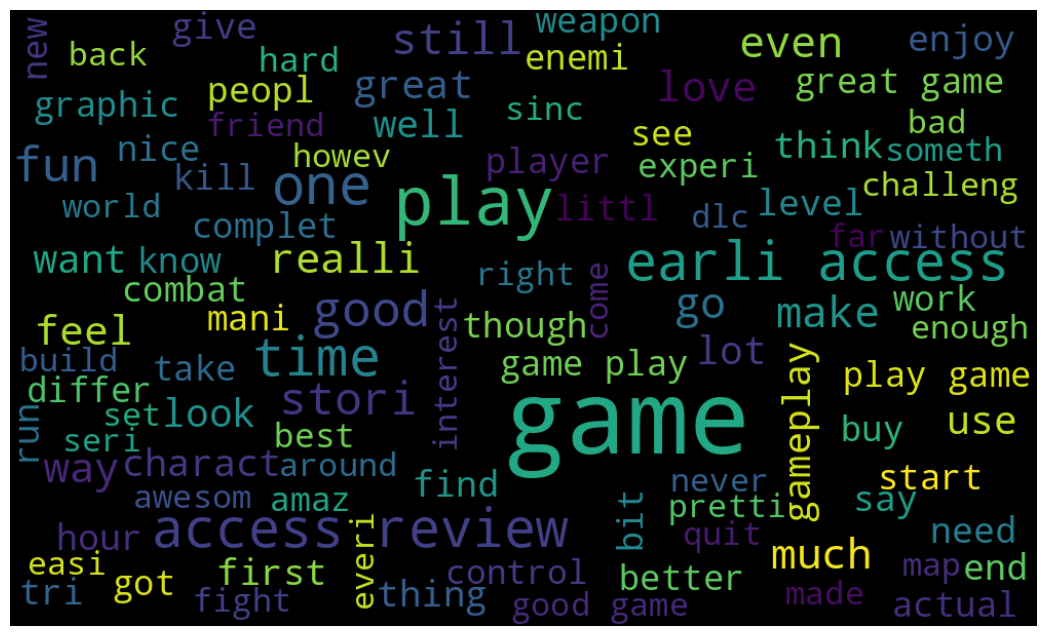

In [ ]:
txt = ' '.join(rev for rev in positive.review_text)

plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)

plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

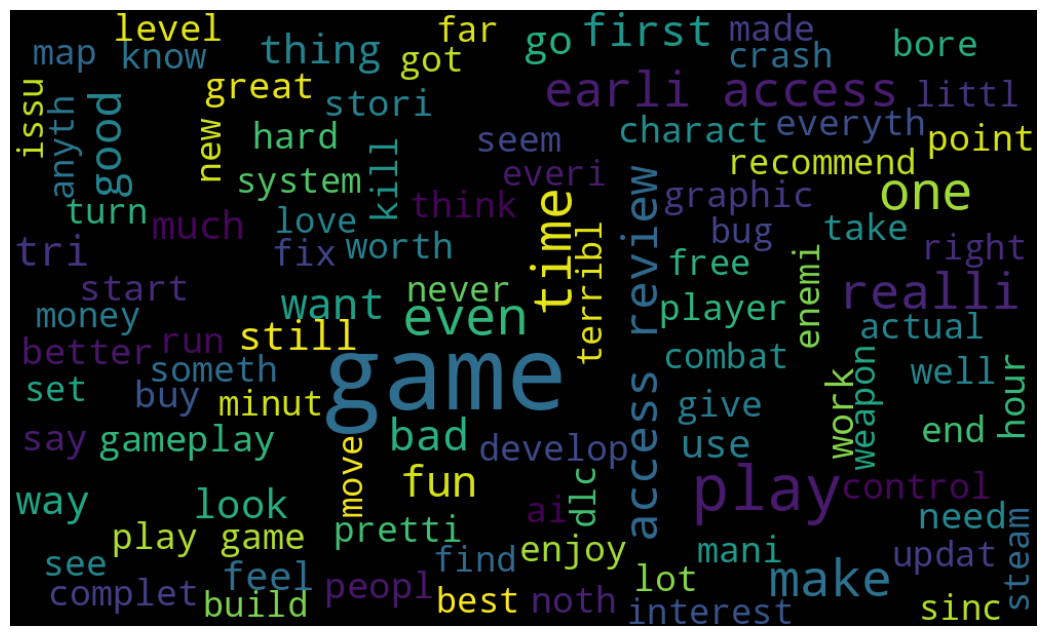

In [ ]:
txt = ' '.join(rev for rev in negative.review_text)

plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)

plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [ ]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

print("Train set shape:", train_data.shape)
print("Test set shape:", test_data.shape)

Train set shape: (4800, 5)
Test set shape: (1200, 5)


In [ ]:
def tokenize_function(examples):
    return tokenizer(examples['review_text'], padding='max_length', truncation=True)

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

train_data['label'] = train_data['review_score']
test_data['label'] = test_data['review_score']

train_data = Dataset.from_pandas(train_data)
test_data = Dataset.from_pandas(test_data)

tokenized_train = train_data.map(tokenize_function, batched=True)
tokenized_test = test_data.map(tokenize_function, batched=True)

tokenized_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
tokenized_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

print(tokenized_train)
print(tokenized_test)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/4676 [00:00<?, ? examples/s]

Map:   0%|          | 0/1169 [00:00<?, ? examples/s]

Dataset({
    features: ['app_id', 'app_name', 'review_text', 'review_score', 'review_votes', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 4676
})
Dataset({
    features: ['app_id', 'app_name', 'review_text', 'review_score', 'review_votes', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 1169
})


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")

   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   return {"accuracy": accuracy, "f1": f1}

In [ ]:
repo_name = "/content/drive/MyDrive/bert-sa-steam"

training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=3,
   weight_decay=0.01,
   save_strategy="epoch"
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

torch.save(model.state_dict(), "/content/drive/MyDrive/bert-sa-steam/bert-sa-steam.pt")

Step,Training Loss
500,0.376800


In [ ]:
trainer.evaluate()

<ipython-input-18-2457e8bb4065>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


{'eval_loss': 0.3793570399284363,
 'eval_accuracy': 0.8554319931565441,
 'eval_f1': 0.9160457029309489,
 'eval_runtime': 20.4676,
 'eval_samples_per_second': 57.115,
 'eval_steps_per_second': 3.615,
 'epoch': 3.0}

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/bert-sa-steam/bert-sa-steam.pt"))
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.sigmoid(logits)
    positive_class_prob = probabilities[:, 1]
    negative_class_prob = probabilities[:, 0]
    if positive_class_prob > negative_class_prob:
      predictions = 1
    else:
      predictions = 0
    return predictions

sentiment_bert = []
sentiment_test = []

# Previsioni sui testi di test
for text in test_data:
    sentiment_test.append(text['review_score'])
    sentiment = predict_sentiment(text['review_text'])
    sentiment_bert.append(sentiment)

data = pd.DataFrame({'Actual': sentiment_test, 'Predicted': sentiment_bert})
data

precision, recall, f1, _ = precision_recall_fscore_support(sentiment_test, sentiment_bert, average='binary')
accuracy = accuracy_score(sentiment_test, sentiment_bert)

metrics = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Accuracy'],
    'Score': [precision, recall, f1, accuracy]
})

print(metrics)

      Metric     Score
0  Precision  0.883142
1     Recall  0.951496
2   F1-Score  0.916046
3   Accuracy  0.855432
